In [1]:
import os
import time

import skimage
from skimage.transform import resize
from skimage.exposure import rescale_intensity
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
import PIL

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset as torchDataset
import torchvision as tv
from torch.autograd import Variable

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Rectangle

import shutil

import pydicom

from utilities import *
# from pneumonia_dataset import PneumoniaDataset

In [2]:
class PneumoniaDataset(torchDataset):
    def __init__(self, data_dir, sample_type, pids, is_predict, boxes_by_pid_dict, rescale_factor=1, transform=None, rotation_angle=0, warping=False):
        """
            data_dir: path to directory containing the data
            sample_type: 'train' or 'test'
            pids: lsit of patient IDs
            is_predict: if true, returns iamge and target labels, otherwise return images
            boxes_by_pid_dict: dictionary of the format { patientId: list of bounding boxes }
            rescale_factor: image rescale factor
            transform: transformation applied to images and target masks
            rotation_angle: float number defining range of rotation angles for augmentation (-rotation_angle, +rotation_angle)
            warping: boolean, if true applying augmentation warping to image, do nothing otherwise
        """

        self.data_dir = os.path.expanduser(data_dir)
        self.sample_type = sample_type
        self.pids = pids
        self.is_predict = is_predict
        self.boxes_by_pid_dict = boxes_by_pid_dict
        self.rescale_factor = rescale_factor
        self.transform = transform
        self.rotation_angle = rotation_angle
        self.warping = warping

        self.images_path = os.path.join(self.data_dir, 'stage_1_' + self.sample_type + '_images/')

    def __getitem__(self, index):
        """
            index: index of the pid
        """
        pid = self.pids[index]

        img = pydicom.dcmread(os.path.join(self.images_path, pid + '.dcm')).pixel_array
        original_image_dim = img.shape[0]
        image_dim = int(original_image_dim / self.rescale_factor)

        img = resize(img, (image_dim, image_dim), mode='reflect')
        img = min_max_scale_image(img, (0, 255))

        if self.warping:
            img = elastic_transform_image(img, image_dim*2, image_dim*0.1)

        img = np.expand_dims(img, -1)
        
        if self.rotation_angle > 0:
            random_angle = self.rotation_angle * (2 * np.random.random_sample() - 1)
            img = tv.transforms.functional.to_pil_image(img)
            img = tv.transforms.functional.rotate(img, random_angle, resample=PIL.Image.BILINEAR)

        if self.transform is not None:
            img = self.transform(img)

        if not self.is_predict:
            target = np.zeros((image_dim, image_dim))
            if pid in self.boxes_by_pid_dict:
                for box in self.boxes_by_pid_dict[pid]:
                    x, y, w, h = box

                    x = int(round(x / rescale_factor))
                    y = int(round(y / rescale_factor))
                    w = int(round(w / rescale_factor))
                    h = int(round(h / rescale_factor))

                    # create mask over the boxes
                    target[y:y+h, x:x+w] = 255
                    target[target > 255] = 255

            target = np.expand_dims(target, -1)
            target = target.astype('uint8')

            if self.rotation_angle > 0:
                target = tv.transforms.functional.to_pil_image(target)
                target = tv.transforms.functional.rotate(target, random_angle, resample=PIL.Image.BILINEAR)

            if self.transform is not None:
                target = self.transform(target)

            return img, target, pid
        else:
            return img, pid

    def __len__(self):
        return len(self.pids)

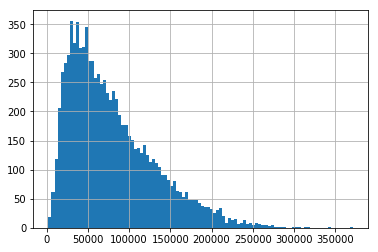

In [3]:
original_dim = 1024
gpu_available = True

timestamp = time.strftime('%m%d-%H%M%S', time.localtime())
data_dir = './data'
output_dir = os.path.join('./output/', timestamp)

train_df = pd.read_csv(os.path.join(data_dir, 'train.csv'))
test_df = pd.read_csv(os.path.join(data_dir, 'test.csv'))

train_df.head(3)

train_df['box_area'] = train_df['width'] * train_df['height']
train_df['box_area'].hist(bins=100)
train_df['box_area'].describe()

min_box_area = 2000

In [4]:
def get_patient_boxes_values(df, p_id):
    '''
    Input:
        df: data frame
        p_id: patient ID
    
    Output:
        array of all bouding boxes and the target's labels
        e.g:
        array([[x1, y1, width1, height1],
               [x2, y2, width2, height2]])
    '''
    boxes = df.loc[df['patientId'] == p_id][['x', 'y', 'width', 'height']].values
    return boxes

In [5]:
validation_prop = 0.1

train_df = train_df.sample(frac=1, random_state=42)
pids = [pid for pid in train_df['patientId'].unique()]

dev_pids = pids[ : int(round(validation_prop * len(pids)))]
train_pids = pids[int(round(validation_prop * len(pids))) : ]
test_pids = test_df['patientId'].unique()

print('Train set: {}'.format(len(train_pids)))
print('Validation set: {}'.format(len(dev_pids)))
print('Test set: {}'.format(len(test_pids)))

boxes_by_pid_dict = {}
for pid in train_df.loc[(train_df['Target'] == 1)]['patientId'].unique().tolist():
    boxes_by_pid_dict[pid] = get_patient_boxes_values(train_df, pid)
print('{} ({:.1f}%) images have bounding boxes'.format(len(boxes_by_pid_dict), 100*(len(boxes_by_pid_dict)/len(pids))))

Train set: 23116
Validation set: 2568
Test set: 1000
5659 (22.0%) images have bounding boxes


Train set: 23116
Validation set: 2568
Test set: 1000


/nfs01/shared_software/anaconda3/envs/gia/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Tensor batch size:  torch.Size([6, 1, 256, 256])
Image and target mask shapes: torch.Size([1, 256, 256]) torch.Size([1, 256, 256])
Patient ID d7539d07-42e4-475c-9ccb-b976b02a32a1
Image value range: 0.0 - 0.9960784316062927
Target mask scale: 0.0 - 0.0


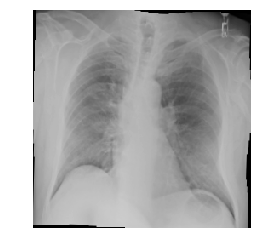

Image and target mask shapes: torch.Size([1, 256, 256]) torch.Size([1, 256, 256])
Patient ID b5c3e1a0-d4ba-413f-b571-809ee8aedf19
Image value range: 0.0 - 0.9529411792755127
Target mask scale: 0.0 - 1.0


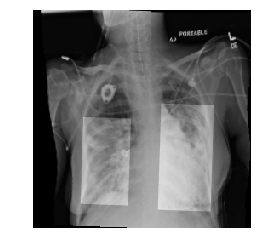

In [6]:
# TODO: change rescale_factor or batch_size
rescale_factor = 4
batch_size = 6

min_box_area = int(round(min_box_area / float(rescale_factor**2)))

# TODO: Add normalization
transform = tv.transforms.Compose([tv.transforms.ToTensor()])

train_dataset = PneumoniaDataset(data_dir=data_dir, sample_type='train', pids=train_pids, is_predict=False,
                                 boxes_by_pid_dict=boxes_by_pid_dict, rescale_factor=rescale_factor, transform=transform,
                                rotation_angle=3, warping=True)
dev_dataset = PneumoniaDataset(data_dir=data_dir, sample_type='train', pids=dev_pids, is_predict=False,
                                 boxes_by_pid_dict=boxes_by_pid_dict, rescale_factor=rescale_factor, transform=transform,
                                rotation_angle=0, warping=False)
test_dataset = PneumoniaDataset(data_dir=data_dir, sample_type='test', pids=test_pids, is_predict=True,
                                 boxes_by_pid_dict=None, rescale_factor=rescale_factor, transform=transform,
                                rotation_angle=0, warping=False)

print('Train set: {}'.format(len(train_dataset)))
print('Validation set: {}'.format(len(dev_dataset)))
print('Test set: {}'.format(len(test_dataset)))

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dataset=dev_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

img_batch, target_batch, pid_batch = next(iter(train_loader))
print('Tensor batch size: ', img_batch.size())

# DEBUG visualization
for i in np.random.choice(len(train_dataset), size=2, replace=False):
    img, target, pid = train_dataset[i]
    print('Image and target mask shapes:', img.shape, target.shape)
    print('Patient ID', pid)
    print('Image value range: {} - {}'.format(img[0].min(), img[0].max()))
    print('Target mask scale: {} - {}'.format(target[0].min(), target[0].max()))
    
    plt.imshow(img[0], cmap=mpl.cm.gist_gray)
    plt.imshow(target[0], cmap=mpl.cm.gist_gray, alpha=0.2)
    plt.axis('off')
    plt.show()


Image shape: torch.Size([1, 256, 256])
Patient ID b5c3e1a0-d4ba-413f-b571-809ee8aedf19
Image value range: 0.0 - 0.9529411792755127


/nfs01/shared_software/anaconda3/envs/gia/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


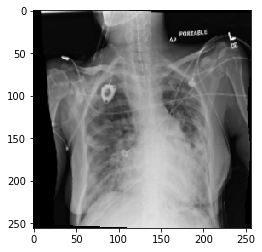

In [7]:
test_img, test_pid = test_dataset[0]
print('Image shape:', test_img.shape)
print('Patient ID', pid)
print('Image value range: {} - {}'.format(img[0].min(), img[0].max()))
plt.imshow(img[0], cmap=mpl.cm.gist_gray)

In [8]:
# TODO: try RELU instead of leaky RELU
class ConvLeakyBlock(nn.Module):
    """
    [conv - batch norm - leaky RELU] block
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1,
                 padding=1, bias=True, bn_momentum=0.9, leaky_slope=0.03):
        super(ConvLeakyBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size,
                             stride=stride, padding=padding, bias=bias)
        self.bn = nn.BatchNorm2d(out_channels, eps=1e-5, momentum=bn_momentum)
        self.activ = nn.LeakyReLU(negative_slope=leaky_slope)
    
    def forward(self, x):
        return self.activ(self.bn(self.conv(x)))

class ConvTransposeLeakyBlock(nn.Module):
    """
    [conv_transpose - batch norm - learky RELU] block
    """
    def __init__(self, in_channels, out_channels, output_size=None, kernel_size=3,
                 bias=True, bn_momentum=0.9, leaky_slope=0.03):
        super(ConvTransposeLeakyBlock, self).__init__()
        self.conv_t = nn.ConvTranspose2d(in_channels, out_channels, kernel_size,
                                         stride=2, padding=1, bias=bias)
        self.bn = nn.BatchNorm2d(out_channels, eps=1e-5, momentum=bn_momentum)
        self.activ = nn.LeakyReLU(negative_slope=leaky_slope)
            
    def forward(self, x, output_size):
        return self.activ(self.bn(self.conv_t(x, output_size=output_size)))
    
class LeakyUNET(nn.Module):
    def __init__(self):
        super(LeakyUNET, self).__init__()
        
        self.down_1 = nn.Sequential(
            ConvLeakyBlock(in_channels=1, out_channels=64),
            ConvLeakyBlock(in_channels=64, out_channels=64)
        )
        self.down_2 = nn.Sequential(
            ConvLeakyBlock(in_channels=64, out_channels=128),
            ConvLeakyBlock(in_channels=128, out_channels=128)
        )
        self.down_3 = nn.Sequential(
            ConvLeakyBlock(in_channels=128, out_channels=256),
            ConvLeakyBlock(in_channels=256, out_channels=256)
        )
        self.down_4 = nn.Sequential(
            ConvLeakyBlock(in_channels=256, out_channels=512),
            ConvLeakyBlock(in_channels=512, out_channels=512)
        )
        self.down_5 = nn.Sequential(
            ConvLeakyBlock(in_channels=512, out_channels=512),
            ConvLeakyBlock(in_channels=512, out_channels=512)
        )
        
        
        self.middle = nn.Sequential(
            ConvLeakyBlock(in_channels=512, out_channels=512),
            ConvLeakyBlock(in_channels=512, out_channels=512)
        )
        self.middle_t = ConvTransposeLeakyBlock(in_channels=512, out_channels=256)
        
        
        self.up_5 = nn.Sequential(
            ConvLeakyBlock(in_channels=768, out_channels=512),
            ConvLeakyBlock(in_channels=512, out_channels=512)
        )
        self.up_5_t = ConvTransposeLeakyBlock(in_channels=512, out_channels=256)
        self.up_4 = nn.Sequential(
            ConvLeakyBlock(in_channels=768, out_channels=512),
            ConvLeakyBlock(in_channels=512, out_channels=512)
        )
        self.up_4_t = ConvTransposeLeakyBlock(in_channels=512, out_channels=128)
        self.up_3 = nn.Sequential(
            ConvLeakyBlock(in_channels=384, out_channels=256),
            ConvLeakyBlock(in_channels=256, out_channels=256)
        )
        self.up_3_t = ConvTransposeLeakyBlock(in_channels=256, out_channels=64)
        self.up_2 = nn.Sequential(
            ConvLeakyBlock(in_channels=192, out_channels=128),
            ConvLeakyBlock(in_channels=128, out_channels=128)
        )
        self.up_2_t = ConvTransposeLeakyBlock(in_channels=128, out_channels=32)
        self.up_1 = nn.Sequential(
            ConvLeakyBlock(in_channels=96, out_channels=64),
            ConvLeakyBlock(in_channels=64, out_channels=1)
        )
    
    def forward(self, x):
        down1 = self.down_1(x) # (1 x 256 x 256 -> 64 x 256 x 256)
        out = F.max_pool2d(down1, kernel_size=2, stride=2) # (64 x 256 x 256 -> 64 x 128 x 128)
        
        down2 = self.down_2(out) # (64 x 128 x 128 -> 128 x 128 x 128)
        out = F.max_pool2d(down2, kernel_size=2, stride=2) # (128 x 128 x 128 -> 128 x 64 x 64)
        
        down3 = self.down_3(out) # (128 x 64 x 64 -> 256 x 64 x 64)
        out = F.max_pool2d(down3, kernel_size=2, stride=2) # (256 x 64 x 64 -> 256 x 32 x 32)
        
        down4 = self.down_4(out) # (256 x 32 x 32 -> 512 x 32 x 32)
        out = F.max_pool2d(down4, kernel_size=2, stride=2) # (512 x 32 x 32 -> 512 x 16 x 16)
        
        down5 = self.down_5(out) # (512 x 16 x 16 -> 512 x 16 x 16)
        out = F.max_pool2d(down5, kernel_size=2, stride=2) # (512 x 16 x 16 -> 512 x 8 x 8)

        out = self.middle(out) # (512 x 8 x 8 -> 512 x 8 x 8)
        out = self.middle_t(out, output_size=down5.size()) # (512 x 8 x 8 -> 256 x 16 x 16)
        
        out = torch.cat([down5, out], 1) # (512 x 16 x 16 concat 256 x 16 x 16 -> 768 x 16 x 16)
        out = self.up_5(out) # (768 x 16 x 16 -> 512 x 16 x 16)
        out = self.up_5_t(out, output_size=down4.size()) # (512 x 16 x 16 -> 256 x 32 x 32)
        
        out = torch.cat([down4, out], 1) # (512 x 32 x 32 concat 256 x 32 x 32 -> 768 x 32 x 32)
        out = self.up_4(out) # (768 x 32 x 32 -> 512 x 32 x 32)
        out = self.up_4_t(out, output_size=down3.size()) # (512 x 32 x 32 -> 128 x 64 x 64)
        
        out = torch.cat([down3, out], 1) # (256 x 64 x 64 concat 128 x 64 x 64 -> 384 x 64 x 64)
        out = self.up_3(out) # (384 x 64 x 64 -> 256 x 64 x 64)
        out = self.up_3_t(out, output_size=down2.size()) # (256 x 64 x 64 -> 64 x 128 x 128)
        
        out = torch.cat([down2, out], 1) # (128 x 128 x 128 concat 64 x 128 x 128 -> 192 x 128 x 128)
        out = self.up_2(out) # (192 x 128 x 128 -> 128 x 128 x 128)
        out = self.up_2_t(out, output_size=down1.size()) # (128 x 128 x 128 -> 32 X 256 x 256)
        
        out = torch.cat([down1, out], 1) # (64 x 256 x 256 concat 32 x 256 x 256 -> 96 x 256 x 256)
        out = self.up_1(out) # (96 x 256 x 256 -> 1 x 256 x 256)
        
        return out
    

class BCEWithLogitLoss2D(nn.Module):
    # Binary Cross Entropy + 2D Sigmoid
    # TODO: focal loss instead of weight
    # TODO: weights for the scores
    
    def __init__(self, weight=None, size_average=True):
        super(BCEWithLogitLoss2D, self).__init__()
        self.loss = nn.BCEWithLogitsLoss(weight, size_average)
        
    def forward(self, scores, targets):
        flat_scores = scores.view(-1)
        flat_targets = targets.view(-1)
        return self.loss(flat_scores, flat_targets)

In [9]:
print(LeakyUNET())

LeakyUNET(
  (down_1): Sequential(
    (0): ConvLeakyBlock(
      (conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (activ): LeakyReLU(negative_slope=0.03)
    )
    (1): ConvLeakyBlock(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (activ): LeakyReLU(negative_slope=0.03)
    )
  )
  (down_2): Sequential(
    (0): ConvLeakyBlock(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (activ): LeakyReLU(negative_slope=0.03)
    )
    (1): ConvLeakyBlock(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_s

In [10]:
def logical_box_mask(box, img_dim=1024):
    """
    Input:
        box: [x, y, w, h] box coordinates
        img_dim: dimension of the image
    Output:
        (np.array of bool) mask
    """
    x, y, w, h = box
    mask = np.zeros((img_dim, img_dim), dtype=bool)
    mask[y:y+h, x:x+w] = True
    return mask

def parse_boxes(prediction_mask, threshold=0.2, connectivity=None):
    """
    Input:
        mask: (torch.Tensor) c x w x h tensor of the prediction mask
        threshold: pixel with value above threshold in the range 0-1 are considered positive target
        connectivity: None, 1 or 2 - connectivity parameter for skimage.measure.label segmentation
    Output:
        (list, list) of predicted_boxes, confidences
    """
    prediction_mask = prediction_mask[0]
    mask = np.zeros(prediction_mask.shape)
    mask[prediction_mask > threshold] = 1.
    
    label = skimage.measure.label(mask, connectivity=connectivity)
    
    predicted_boxes = []
    confidences = []
    for region in skimage.measure.regionprops(label):
        y1, x1, y2, x2 = region.bbox
        h = y2 - y1
        w = x2 - x1
        
        c = np.nanmean(prediction_mask[y1:y2, x1:x2])
        
        if w*h > min_box_area:
            predicted_boxes.append([x1, y1, w, h])
            confidences.append(c)
        
    return predicted_boxes, confidences

# plt.imshow(train_dataset[3][1][0], cmap=mpl.cm.jet) 
# print(train_dataset[3][1].shape)
# print(parse_boxes(train_dataset[3][1]))


def prediction_output(predicted_boxes, confidences):
    """
    Input:
        predicted_boxes: [[x1, y1, w1, h1], [x2, y2, w2, h2], ...] list of predicted boxes' coordinates
        confidences: [c1, c2, ...] list of confidence values for the predicted boxes
    Output:
        'c1 x1 y1 w1 h1 x2 c2 y2 w2 h2 ...'
    """
    output = ''
    for c, box in zip(confidences, predicted_boxes):
        output += ' ' + str(c) + ' ' + ' '.join([str[b] for b in box])
    return output[1:]

def IoU(prediction_mask, ground_mask):
    """
    Input:
        prediction_mask: (numpy_array(bool)) predicted mask with bounding boxes masked as True
        ground_mask: (numpy_array(bool)) ground truth mask with bounding boxes masked as True
    Output:
        intersection(prediction_mask, ground_mask) / union(prediction_mask, ground_truth)
    """
    IoU = (prediction_mask & ground_mask).sum() / ((prediction_mask | ground_mask).sum() + 1.e-9)
    return IoU

def precision(tp, fp, fn):
    """
    Input:
        tp: (int) number of true positives
        fp: (int) number of false positives
        fn: (int) number of false negatives
    Output:
        precision
    """
    return float(tp) / (tp + fp + fn + 1.e-9)

def average_image_precision(predicted_boxes, confidences, target_boxes, img_dim=1024):
    """
    Input:
        predicted_boxes: [[x1, y1, w1, h1], [x2, y2, w2, h2], ...] list of predicted boxes' coordinates
        confidences: [c1, c2, ...] list of confidence values of the predicted boxes
        target_boxes: [[x1, y1, w1, h1], [x2, y2, w2, h2], ...] list of target boxes' coordinates
        img_dim: dimension of the boolean masks
    Output:
        Average precision
    """
    
    if len(predicted_boxes) == 0 and len(target_boxes) == 0:
        return np.nan
    else:
        if len(predicted_boxes) > 0 and len(target_boxes) == 0:
            return 0.0
        elif len(target_boxes) == 0 and len(predicted_boxes) == 0:
            return 0.0
        else:
            thresholds = np.arange(0.4, 0.8, 0.05)
            confidence_sorted_predicted_boxes = list(reversed(
                [b for _, b in sorted(zip(confidences, predicted_boxes),
                                      key=lambda pair:pair[0])]))
            average_precision = 0.0
            for thresh in thresholds:
                tp = 0
                fp = len(predicted_boxes)
                for predicted_box in confidence_sorted_predicted_boxes:
                    predicted_box_mask = logical_box_mask(predicted_box, img_dim)
                    for target_box in target_boxes:
                        target_box_mask = logical_box_mask(target_box, img_dim)
                        iou = IoU(predicted_box_mask, target_box_mask)
                        if iou > thresh:
                            tp += 1
                            fp -= 1
                            break

                fn = len(target_boxes)
                for target_box in target_boxes:
                    target_box_mask = logical_box_mask(target_box, img_dim)
                    for predicted_box in confidence_sorted_predicted_boxes:
                        predicted_box_mask = logical_box_mask(predicted_box, img_dim)
                        iou = IoU(predicted_box_mask, target_box_mask)
                        if iou > thresh:
                            fn -= 1
                            break
                
                average_precision += precision(tp, fp, fn) / float(len(thresholds))
            return average_precision
        
def average_batch_precision(output_batch, pids, boxes_by_pid_dict, rescale_factor, img_dim=1024, return_array=False):
    """
    Input:
        output_batch: output batch of the model
        pids: list of patient IDs in the batch
        boxes_by_pid_dict: dict of boxes given patient ID
        rescale_factor: rescale factor of the image
        img_dim: dimension of the image
    Output:
        average precision of the batch
    """
    
    batch_precisions = []
    for mask, pid in zip(output_batch, pids):
        target_boxes = boxes_by_pid_dict[pid] if pid in boxes_by_pid_dict else []
        if len(target_boxes) > 0:
            target_boxes = [[int(round(c/float(rescale_factor))) for c in target_box] for target_box in target_boxes]
        predicted_boxes, confidences = parse_boxes(mask)
        batch_precisions.append(average_image_precision(predicted_boxes, confidences, target_boxes, img_dim=img_dim))
        
    if return_array:
        return np.asarray(batch_precisions)
    else:
        return np.nanmean(np.asarray(batch_precisions))

class RunningAverage():
    def __init__(self):
        self.steps = 0
        self.total = 0
    
    def update(self, val):
        self.total += val
        self.steps += 1
        
    def __call__(self):
        return self.total / float(self.steps)

In [11]:
def save_checkpoint(state, is_best, metric):
    """
    Input:
        state: (dict) model's state_dict
        is_best: (bool) True if it is the best model yet
        metric: name of the metric
    """
    filename = 'last_checkpoint.pth.rar'
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, metric + '.best.pth.rar')

In [12]:
def train(model, dataloader, optimizer, loss_fn, num_steps, boxes_by_pid_dict, rescale_factor,
          img_dim, save_checkpoint_interval=5):
    model.train()
    
    summary = []
    average_loss = RunningAverage()
    
    average_loss_hist, loss_hist, precision_hist = [], [], []
    
    start = time.time()
    
    for i, (input_batch, labels_batch, pids_batch) in enumerate(dataloader):
        if i > num_steps:
            break
            
        input_batch = Variable(input_batch).cuda(async=True) if gpu_available else Variable(input_batch).float()
        labels_batch = Variable(labels_batch).cuda(async=True) if gpu_available else Variable(labels_batch).float()
        
        
        optimizer.zero_grad()
        output_batch = model(input_batch)
        
        loss = loss_fn(output_batch, labels_batch)
        
        loss.backward()
        optimizer.step()
        
        loss_hist.append(loss.item())
        average_loss.update(loss.item())
        average_loss_hist.append(average_loss())
        
        if i % save_checkpoint_interval == 0:
            output_batch= output_batch.data.cpu().numpy()
            
            batch_precision = average_batch_precision(output_batch, pids_batch, boxes_by_pid_dict,
                                                     rescale_factor, img_dim)
            precision_hist.append(batch_precision)
            
            log = "batch loss = {:05.7f} ; ".format(loss.item())
            log += "average loss = {:05.7f} ; ".format(average_loss())
            log += "batch precision = {:05.7f} ; ".format(batch_precision)
            print('--- Train batch {} / {}: '.format(i, num_steps) + log)
            time_delta = time.time() - start
            print("    {:.2f} seconds".format(time_delta))
            start = time.time()
            
    metrics = "average loss = {:05.7f} ; ".format(average_loss())
    print("- Train epoch metrics: ".format(metrics))
    
    return average_loss_hist, loss_hist, precision_hist
        

In [13]:
def evaluate(model, dataloader, loss_fn, num_steps, boxes_by_pid_dict, rescale_factor, img_dim):
    model.eval()
    
    losses = []
    precisions = []
    
    start = time.time()
    for i, (input_batch, labels_batch, pids_batch) in enumerate(dataloader):
        if i > num_steps:
            break
        
        input_batch = Variable(input_batch).cuda(async=True) if gpu_available else Variable(input_batch).float()
        labels_batch = Variable(labels_batch).cuda(async=True) if gpu_available else Variable(labels_batch).float()
        
        output_batch = model(input_batch)
        
        loss = loss_fn(output_batch, labels_batch)
        losses.append(loss.item())
        
        output_batch = output_batch.data.cpu()
        
        batch_precision = average_batch_precision(output_batch, pids_batch, boxes_by_pid_dict, rescale_factor, img_dim, return_array=True)
        for p in batch_precision:
            precisions.append(p)
        print('--- Validation batch {} / {}: '.format(i, num_steps))

    
    mean_metrics = {'loss' : np.nanmean(losses),
                    'precision' : np.nanmean(np.asarray(precisions))}
    metrics = "average loss = {:05.7f} ; ".format(mean_metrics['loss'])
    metrics += "average precision = {:05.7f}; ".format(mean_metrics['precision'])
    print("- Eval metrics: " + metrics)
    time_delta = time.time() - start
    print(' Time {:.2f} seconds'.format(time_delta))
    
    return mean_metrics

In [14]:
def train_and_evaluate(model, train_dataloader, dev_dataloader, init_learning_rate, loss_fn,
                      num_epochs, num_train_steps, num_dev_steps, boxes_by_pid_dict,
                       rescale_factor, img_dim, saved_file=None):
    if saved_file is not None:
        checkpoint = torch.load(saved_file)
        model.load_state_dict(checkpoint['model_state'])
        
    best_dev_loss = 1e+15
    best_dev_precision = 0.0
    best_loss_model = None
    best_precision_model = None
    
    train_loss_hist = []
    dev_loss_hist = []
    average_train_loss_hist = []
    train_precision_hist = []
    dev_precision_hist = []
    
    for epoch in range(num_epochs):
        start = time.time()
        
        # TODO: check this
        learning_rate = init_learning_rate * 0.5**float(epoch)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        
        print("Epoch {}/{}. Learning rate = {:05.3f}".format(epoch + 1, num_epochs, learning_rate))
        
        epoch_average_train_loss_hist, epoch_train_loss_hist, epoch_train_precision_hist = train(model, train_dataloader,
                optimizer, loss_fn, num_train_steps, boxes_by_pid_dict, rescale_factor, img_dim)
        
        average_train_loss_hist += epoch_average_train_loss_hist
        train_loss_hist += epoch_train_loss_hist
        train_precision_hist += epoch_train_precision_hist
        
        
        dev_metrics = evaluate(model, dev_dataloader, loss_fn, num_dev_steps, boxes_by_pid_dict,
                              rescale_factor, img_dim)
        
        dev_loss = dev_metrics['loss']
        dev_precision = dev_metrics['precision']
        
        dev_loss_hist += len(epoch_train_loss_hist) * [dev_loss]
        dev_precision_hist += len(train_precision_hist) * [dev_precision]
        
        is_best_loss = dev_loss <= best_dev_loss
        is_best_precision = dev_precision >= best_dev_precision
        
        if is_best_loss:
            print("- New best loss: {:.4f}".format(dev_loss))
            best_dev_loss = dev_loss
            best_loss_model = model
        if is_best_precision:
            print("- New best precision: {:.4f}".format(dev_precision))
            best_dev_precision = dev_precision
            best_precision_model = model
        
        save_checkpoint({'epoch': epoch + 1,
                         'model_state': model.state_dict(),
                         'optimizer_state': optimizer.state_dict()},
                       is_best=is_best_loss,
                       metric='loss')
        save_checkpoint({'epoch': epoch + 1,
                         'model_state': model.state_dict(),
                         'optimizer_state': optimizer.state_dict()},
                       is_best=is_best_precision,
                       metric='precision')
        
        time_delta = time.time() - start
        print('Epoch time {:.2f} minutes'.format(time_delta / 60.))
        
    histories = {'average train loss': average_train_loss_hist,
                 'train loss': train_loss_hist,
                 'train precision': train_precision_hist,
                 'dev loss': dev_loss_hist }
    best_models = {'best loss model': best_loss_model,
                  'best precision model': best_precision_model}
    
    
    return histories, best_models

In [15]:
def predict(model, dataloader):
    model.eval()
    
    predictions = {}
    
    for i, (test_batch, pids) in enumerate(dataloader):
        print('Predicting batch {} / {} : '.format(i+1, len(dataloader)))
        
        test_batch = Variable(test_batch).cuda(async=True) if gpu_available else Variable(test_batch).float()
        
        sig = nn.Sigmoid().cuda()
        output_batch = model(test_batch)
        output_batch = sig(output_batch)
        output_batch = output_batch.data.cpu().numpy()
        
        for pid, output in zip(pids, output_batch):
            predictions[pid] = output
        
    return predictions

In [16]:
debug = True

model = LeakyUNET().cuda() if gpu_available else LeakyUNET()

loss_fn = BCEWithLogitLoss2D().cuda() if gpu_available else BCEWithLogitLoss2D()

init_learning_rate = 0.5

num_epochs = 2 if debug else 2
num_train_steps = 20 if debug else len(train_loader)
num_dev_steps = 10 if debug else len(dev_loader)

img_dim = int(round(original_dim / rescale_factor))

print("Training for {} epochs".format(num_epochs))
historis, best_models = train_and_evaluate(model, train_loader, dev_loader, init_learning_rate,
                                          loss_fn, num_epochs, num_train_steps, num_dev_steps,
                                          boxes_by_pid_dict, rescale_factor, img_dim)

Training for 2 epochs
Epoch 1/2. Learning rate = 0.500


/nfs01/shared_software/anaconda3/envs/gia/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


--- Train batch 0 / 20: batch loss = 0.7822158 ; average loss = 0.7822158 ; batch precision = 0.0000000 ; 
    2.46 seconds
--- Train batch 5 / 20: batch loss = 0.6703868 ; average loss = 0.6983034 ; batch precision = 0.0000000 ; 
    4.11 seconds
--- Train batch 10 / 20: batch loss = 0.6579444 ; average loss = 0.6814745 ; batch precision = 0.0000000 ; 
    4.87 seconds
--- Train batch 15 / 20: batch loss = 0.6496341 ; average loss = 0.6721395 ; batch precision = 0.0000000 ; 
    4.71 seconds
--- Train batch 20 / 20: batch loss = 0.6533348 ; average loss = 0.6658604 ; batch precision = 0.0000000 ; 
    4.33 seconds
- Train epoch metrics: 
--- Validation batch 0 / 10: 
--- Validation batch 1 / 10: 
--- Validation batch 2 / 10: 
--- Validation batch 3 / 10: 
--- Validation batch 4 / 10: 
--- Validation batch 5 / 10: 
--- Validation batch 6 / 10: 
--- Validation batch 7 / 10: 
--- Validation batch 8 / 10: 
--- Validation batch 9 / 10: 
--- Validation batch 10 / 10: 
- Eval metrics: averag

/nfs01/shared_software/anaconda3/envs/gia/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: Mean of empty slice


--- Train batch 20 / 20: batch loss = 0.5663081 ; average loss = 0.6027888 ; batch precision = 00nan ; 
    4.00 seconds
- Train epoch metrics: 
--- Validation batch 0 / 10: 
--- Validation batch 1 / 10: 
--- Validation batch 2 / 10: 
--- Validation batch 3 / 10: 
--- Validation batch 4 / 10: 
--- Validation batch 5 / 10: 
--- Validation batch 6 / 10: 
--- Validation batch 7 / 10: 
--- Validation batch 8 / 10: 
--- Validation batch 9 / 10: 
--- Validation batch 10 / 10: 
- Eval metrics: average loss = 0.5999461 ; average precision = 0.0000000; 
 Time 8.21 seconds
- New best loss: 0.5999
- New best precision: 0.0000
Epoch time 0.80 minutes
